# Zhanibek Meiramkan ADA-2404M

# **Practice 4**

In [9]:
%%writefile practice4.cu
#include <cuda_runtime.h> // cuda
#include <iostream> // вывод
#include <vector> // вектор
#include <cstdlib> // rand
#include <ctime> // time
#include <algorithm> // is_sorted

using namespace std; // чтоб не писать std::

void cuda_ok(cudaError_t err, const char* msg) { // проверка cuda
    if (err != cudaSuccess) { // если ошибка
        cout << "ошибка cuda (" << msg << "): " << cudaGetErrorString(err) << "\n"; // вывод
        exit(1); // выход
    }
}

// часть 2 — редукция суммы (global vs shared)

__global__ void reduce_global_atomic(const int* data, int* out, int n) { // редукция только global
    int idx = blockIdx.x * blockDim.x + threadIdx.x; // индекс
    if (idx < n) { // граница
        atomicAdd(out, data[idx]); // атомарно в сумму
    }
}

__global__ void reduce_shared_blocks(const int* data, int* out, int n) { // редукция через shared + 1 atomic на блок
    __shared__ int sh[256]; // shared на 256
    int tid = threadIdx.x; // поток
    int idx = blockIdx.x * blockDim.x + tid; // индекс
    sh[tid] = (idx < n) ? data[idx] : 0; // грузим или 0
    __syncthreads(); // ждем
    for (int s = blockDim.x / 2; s > 0; s /= 2) { // 128 64 32 ...
        if (tid < s) { // половина
            sh[tid] += sh[tid + s]; // складываем
        }
        __syncthreads(); // синхро
    }
    if (tid == 0) { // один поток
        atomicAdd(out, sh[0]); // сумма блока
    }
}

// часть 3 — сортировка (локальный пузырек + merge)

__global__ void sort_bubble_local(int* data, int n, int chunk) { // пузырек на чанках (локальная память)
    int tid = blockIdx.x * blockDim.x + threadIdx.x; // id
    int start = tid * chunk; // начало
    if (start >= n) return; // граница
    int len = chunk; // длина
    if (start + len > n) len = n - start; // хвост
    int local[32]; // локальный буфер (chunk = 32)
    for (int i = 0; i < len; i++) local[i] = data[start + i]; // загрузка
    for (int i = 0; i < len; i++) { // пузырек
        for (int j = 0; j + 1 < len - i; j++) { // проход
            if (local[j] > local[j + 1]) { // swap
                int tmp = local[j]; // tmp
                local[j] = local[j + 1]; // swap
                local[j + 1] = tmp; // swap
            }
        }
    }
    for (int i = 0; i < len; i++) data[start + i] = local[i]; // назад
}

__global__ void merge_pairs_shared(const int* in, int* out, int n, int seg) { // merge через shared (маленькие seg)
    int pair_id = blockIdx.x; // пара
    int start = pair_id * (2 * seg); // начало
    if (start >= n) return; // граница
    int mid = start + seg; // середина
    int end = start + 2 * seg; // конец
    if (mid > n) mid = n; // граница
    if (end > n) end = n; // граница
    int left_len = mid - start; // левый
    int right_len = end - mid; // правый
    extern __shared__ int sh[]; // shared
    int* L = sh; // left
    int* R = sh + seg; // right
    int t = threadIdx.x; // поток
    for (int i = t; i < left_len; i += blockDim.x) L[i] = in[start + i]; // копия L
    for (int i = t; i < right_len; i += blockDim.x) R[i] = in[mid + i]; // копия R
    __syncthreads(); // ждем
    if (t == 0) { // один поток merge
        int i = 0; // L
        int j = 0; // R
        int k = start; // out
        while (i < left_len && j < right_len) { // пока оба есть
            if (L[i] <= R[j]) out[k++] = L[i++]; // L
            else out[k++] = R[j++]; // R
        }
        while (i < left_len) out[k++] = L[i++]; // остаток
        while (j < right_len) out[k++] = R[j++]; // остаток
    }
}

__global__ void merge_pairs_global(const int* in, int* out, int n, int seg) { // merge через global (большие seg)
    int pair_id = blockIdx.x; // пара
    int start = pair_id * (2 * seg); // начало
    if (start >= n) return; // граница
    int mid = start + seg; // середина
    int end = start + 2 * seg; // конец
    if (mid > n) mid = n; // граница
    if (end > n) end = n; // граница
    int i = start; // left idx
    int j = mid; // right idx
    int k = start; // out idx
    while (i < mid && j < end) { // merge
        int a = in[i]; // left
        int b = in[j]; // right
        if (a <= b) { out[k++] = a; i++; } // left
        else { out[k++] = b; j++; } // right
    }
    while (i < mid) out[k++] = in[i++]; // остаток
    while (j < end) out[k++] = in[j++]; // остаток
}

float run_reduce_global(const vector<int>& h, int& out_sum) { // запуск global редукции
    int n = (int)h.size(); // n
    int bytes = n * (int)sizeof(int); // байты
    int *d = nullptr, *d_out = nullptr; // ptr
    cuda_ok(cudaMalloc(&d, bytes), "malloc data"); // malloc
    cuda_ok(cudaMalloc(&d_out, (int)sizeof(int)), "malloc out"); // malloc
    cuda_ok(cudaMemcpy(d, h.data(), bytes, cudaMemcpyHostToDevice), "copy H2D"); // copy
    cuda_ok(cudaMemset(d_out, 0, (int)sizeof(int)), "memset out"); // 0
    int block = 256; // block
    int grid = (n + block - 1) / block; // grid
    cudaEvent_t s, e; cudaEventCreate(&s); cudaEventCreate(&e); // events
    cudaEventRecord(s); // start
    reduce_global_atomic<<<grid, block>>>(d, d_out, n); // kernel
    cuda_ok(cudaGetLastError(), "kernel reduce_global"); // check
    cudaEventRecord(e); cudaEventSynchronize(e); // stop
    float ms = 0.0f; cudaEventElapsedTime(&ms, s, e); // ms
    cuda_ok(cudaMemcpy(&out_sum, d_out, (int)sizeof(int), cudaMemcpyDeviceToHost), "copy sum D2H"); // sum
    cudaEventDestroy(s); cudaEventDestroy(e); // destroy
    cudaFree(d); cudaFree(d_out); // free
    return ms; // ms
}

float run_reduce_shared(const vector<int>& h, int& out_sum) { // запуск shared редукции
    int n = (int)h.size(); // n
    int bytes = n * (int)sizeof(int); // байты
    int *d = nullptr, *d_out = nullptr; // ptr
    cuda_ok(cudaMalloc(&d, bytes), "malloc data"); // malloc
    cuda_ok(cudaMalloc(&d_out, (int)sizeof(int)), "malloc out"); // malloc
    cuda_ok(cudaMemcpy(d, h.data(), bytes, cudaMemcpyHostToDevice), "copy H2D"); // copy
    cuda_ok(cudaMemset(d_out, 0, (int)sizeof(int)), "memset out"); // 0
    int block = 256; // block
    int grid = (n + block - 1) / block; // grid
    cudaEvent_t s, e; cudaEventCreate(&s); cudaEventCreate(&e); // events
    cudaEventRecord(s); // start
    reduce_shared_blocks<<<grid, block>>>(d, d_out, n); // kernel
    cuda_ok(cudaGetLastError(), "kernel reduce_shared"); // check
    cudaEventRecord(e); cudaEventSynchronize(e); // stop
    float ms = 0.0f; cudaEventElapsedTime(&ms, s, e); // ms
    cuda_ok(cudaMemcpy(&out_sum, d_out, (int)sizeof(int), cudaMemcpyDeviceToHost), "copy sum D2H"); // sum
    cudaEventDestroy(s); cudaEventDestroy(e); // destroy
    cudaFree(d); cudaFree(d_out); // free
    return ms; // ms
}

float run_sort_gpu(const vector<int>& h, bool& sorted_ok) { // запуск сортировки
    int n = (int)h.size(); // n
    int bytes = n * (int)sizeof(int); // bytes
    int *a = nullptr, *b = nullptr; // ping pong
    cuda_ok(cudaMalloc(&a, bytes), "malloc a"); // malloc
    cuda_ok(cudaMalloc(&b, bytes), "malloc b"); // malloc
    cuda_ok(cudaMemcpy(a, h.data(), bytes, cudaMemcpyHostToDevice), "copy H2D a"); // copy

    const int chunk = 32; // чанк
    int threads = 256; // threads
    int chunks_total = (n + chunk - 1) / chunk; // чанков
    int blocks = (chunks_total + threads - 1) / threads; // blocks

    cudaEvent_t s, e; cudaEventCreate(&s); cudaEventCreate(&e); // events
    cudaEventRecord(s); // start

    sort_bubble_local<<<blocks, threads>>>(a, n, chunk); // bubble
    cuda_ok(cudaGetLastError(), "kernel bubble"); // check

    int seg = chunk; // сегмент
    bool flip = false; // flip
    const int seg_shared_max = 2048; // safe seg

    while (seg < n) { // merge loop
        int pairs = (n + (2 * seg) - 1) / (2 * seg); // pairs
        const int* in = flip ? (const int*)b : (const int*)a; // in
        int* out = flip ? a : b; // out

        if (seg <= seg_shared_max) { // shared merge
            int sh_bytes = (2 * seg) * (int)sizeof(int); // bytes
            merge_pairs_shared<<<pairs, 256, sh_bytes>>>(in, out, n, seg); // kernel
            cuda_ok(cudaGetLastError(), "kernel merge shared"); // check
        } else { // global merge
            merge_pairs_global<<<pairs, 1>>>(in, out, n, seg); // kernel
            cuda_ok(cudaGetLastError(), "kernel merge global"); // check
        }

        flip = !flip; // swap buffers
        seg *= 2; // seg x2
    }

    cudaEventRecord(e); cudaEventSynchronize(e); // stop
    float ms = 0.0f; cudaEventElapsedTime(&ms, s, e); // time

    vector<int> out_h(n); // cpu
    int* last = flip ? b : a; // last
    cuda_ok(cudaMemcpy(out_h.data(), last, bytes, cudaMemcpyDeviceToHost), "copy sorted D2H"); // copy
    sorted_ok = is_sorted(out_h.begin(), out_h.end()); // check

    cudaEventDestroy(s); cudaEventDestroy(e); // destroy
    cudaFree(a); cudaFree(b); // free
    return ms; // ms
}

int main() { // main
    srand((unsigned)time(0)); // seed
    int sizes[3] = {10000, 100000, 1000000}; // sizes

    // вывод строго CSV, чтобы потом строить графики
    cout << "n,reduce_global_ms,reduce_shared_ms,sort_ms,sum_ok,sort_ok\n"; // header

    for (int t = 0; t < 3; t++) { // loop
        int n = sizes[t]; // n
        vector<int> h(n); // array
        for (int i = 0; i < n; i++) h[i] = rand() % 10; // fill

        int sum_g = 0; // sum global
        int sum_s = 0; // sum shared
        float ms_g = run_reduce_global(h, sum_g); // time global
        float ms_s = run_reduce_shared(h, sum_s); // time shared

        bool sum_ok = (sum_g == sum_s); // check sum

        bool sort_ok = false; // check sort
        float ms_sort = run_sort_gpu(h, sort_ok); // time sort

        cout << n << "," << ms_g << "," << ms_s << "," << ms_sort << "," << (sum_ok ? 1 : 0) << "," << (sort_ok ? 1 : 0) << "\n"; // row
    }

    return 0; // end
}


Overwriting practice4.cu


In [10]:
!nvcc -O2 practice4.cu -o practice4 -gencode arch=compute_75,code=sm_75
!./practice4 > results.csv
!cat results.csv


n,reduce_global_ms,reduce_shared_ms,sort_ms,sum_ok,sort_ok
10000,0.266272,0.04128,4.67354,1,1
100000,0.010688,0.016384,43.5184,1,1
1000000,0.053248,0.100352,307.379,1,1


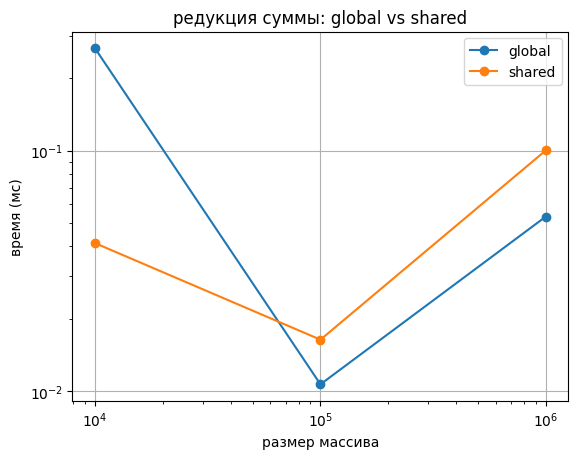

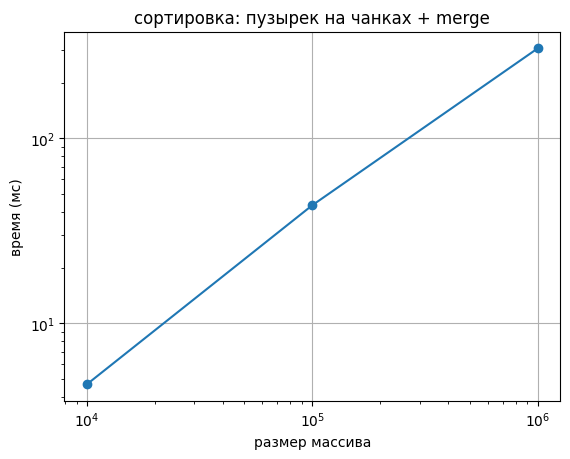

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("results.csv")

plt.figure()
plt.plot(df["n"], df["reduce_global_ms"], marker="o")
plt.plot(df["n"], df["reduce_shared_ms"], marker="o")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("размер массива")
plt.ylabel("время (мс)")
plt.title("редукция суммы: global vs shared")
plt.legend(["global", "shared"])
plt.grid(True)
plt.show()

plt.figure()
plt.plot(df["n"], df["sort_ms"], marker="o")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("размер массива")
plt.ylabel("время (мс)")
plt.title("сортировка: пузырек на чанках + merge")
plt.grid(True)
plt.show()
